<a href="https://colab.research.google.com/github/dmklee/image2sphere/blob/main/model_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook walks you through the components of the I2S model introduced in "Image to Sphere: Learning Equivariant Features for Efficient Pose Prediction" (2023).  The I2S model is designed to leverage the SO(3) symmetry present in the object pose estimation task to improve reasoning from single view images. 

In [ ]:
%%capture
! pip install e3nn scipy matplotlib torchvision healpy

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToPILImage
import e3nn
from e3nn import o3
import healpy as hp
import matplotlib.pyplot as plt

## 1. Define Image Encoder
The first step in I2S is to use a traditional vision model to encode an image into a dense feature map.  In the paper, we use a ResNet50 pretrained on ImageNet-1K.  Here, we show an example using a Swin Transformer.

In [ ]:
class ImageEncoder(nn.Module):
  '''Define an image encoding network to process image into dense feature map

  Any standard convolutional network or vision transformer could be used here. 
  In the paper, we use ResNet50 pretrained on ImageNet1K for a fair comparison to
  the baselines.  Here, we show an example using a pretrained SWIN Transformer.

  When using a model from torchvision, make sure to remove the head so the output
  is a feature map, not a feature vector
  '''
  def __init__(self):
    super().__init__()
    self.layers = torchvision.models.swin_v2_t(weights="DEFAULT")

    # last three modules in swin are avgpool,flatten,linear so change to Identity
    self.layers.avgpool = nn.Identity()
    self.layers.flatten = nn.Identity()
    self.layers.head = nn.Identity()

    # we will need shape of feature map for later
    dummy_input = torch.zeros((1, 3, 224, 224))
    self.output_shape = self(dummy_input).shape[1:]
  
  def forward(self, x):
    return self.layers(x)

# 2. Define Projector from Image space to Spherical Harmonics
We project the image representation onto the sphere using orthographic projection.  The sphere is a more natural domain for the SO(3) pose estimation problem, and allows us to leverage SO(3) equivariant layers.

In [ ]:
def s2_healpix_grid(rec_level: int=0, max_beta: float=np.pi/6):
    """Returns healpix grid up to a max_beta
    """
    n_side = 2**rec_level
    npix = hp.nside2npix(n_side)
    m = hp.query_disc(nside=n_side, vec=(0,0,1), radius=max_beta)
    beta, alpha = hp.pix2ang(n_side, m)
    alpha = torch.from_numpy(alpha)
    beta = torch.from_numpy(beta)
    return torch.stack((alpha, beta)).float()


class Image2SphereProjector(nn.Module):
  '''Define orthographic projection from image space to half of sphere, returning
  coefficients of spherical harmonics

  :fmap_shape: shape of incoming feature map (channels, height, width)
  :fdim_sphere: dimensionality of featuremap projected to sphere
  :lmax: maximum degree of harmonics
  :coverage: fraction of feature map that is projected onto sphere
  :sigma: stdev of gaussians used to sample points in image space
  :max_beta: maximum azimuth angle projected onto sphere (np.pi/2 corresponds to half sphere)
  :taper_beta: if less than max_beta, taper magnitude of projected features beyond this angle
  :rec_level: recursion level of healpy grid where points are projected
  :n_subset: number of grid points used to perform projection, acts like dropout regularizer
  '''
  def __init__(self,
               fmap_shape, 
               sphere_fdim: int,
               lmax: int,
               coverage: float = 0.9,
               sigma: float = 0.2,
               max_beta: float = np.radians(90),
               taper_beta: float = np.radians(75),
               rec_level: int = 2,
               n_subset: int = 20,
              ):
    super().__init__()
    self.lmax = lmax
    self.n_subset = n_subset

    # point-wise linear operation to convert to proper dimensionality if needed
    if fmap_shape[0] != sphere_fdim:
      self.conv1x1 = nn.Conv2d(fmap_shape[0], sphere_fdim, 1)
    else:
      self.conv1x1 = nn.Identity()

    # determine sampling locations for orthographic projection
    self.kernel_grid = s2_healpix_grid(max_beta=max_beta, rec_level=rec_level)
    self.xyz = o3.angles_to_xyz(*self.kernel_grid)

    # orthographic projection
    max_radius = torch.linalg.norm(self.xyz[:,[0,2]], dim=1).max()
    sample_x = coverage * self.xyz[:,2] / max_radius # range -1 to 1
    sample_y = coverage * self.xyz[:,0] / max_radius

    gridx, gridy = torch.meshgrid(2*[torch.linspace(-1, 1, fmap_shape[1])], indexing='ij')
    scale = 1 / np.sqrt(2 * np.pi * sigma**2)
    data = scale * torch.exp(-((gridx.unsqueeze(-1) - sample_x).pow(2) \
                                +(gridy.unsqueeze(-1) - sample_y).pow(2)) / (2*sigma**2) )
    data = data / data.sum((0,1), keepdims=True)

    # apply mask to taper magnitude near border if desired
    betas = self.kernel_grid[1]
    if taper_beta < max_beta:
        mask = ((betas - max_beta)/(taper_beta - max_beta)).clamp(max=1).view(1, 1, -1)
    else:
        mask = torch.ones_like(data)

    data = (mask * data).unsqueeze(0).unsqueeze(0).to(torch.float32)
    self.weight = nn.Parameter(data= data, requires_grad=True)

    self.n_pts = self.weight.shape[-1]
    self.ind = torch.arange(self.n_pts)

    self.register_buffer(
        "Y", o3.spherical_harmonics_alpha_beta(range(lmax+1), *self.kernel_grid, normalization='component')
    )

  def forward(self, x):
    '''
    :x: float tensor of shape (B, C, H, W)
    :return: feature vector of shape (B,P,C) where P is number of points on S2
    '''
    x = self.conv1x1(x)

    if self.n_subset is not None:
        self.ind = torch.randperm(self.n_pts)[:self.n_subset]

    x = (x.unsqueeze(-1) * self.weight[..., self.ind]).sum((2,3))
    x = torch.relu(x)
    x = torch.einsum('ni,xyn->xyi', self.Y[self.ind], x) / self.ind.shape[0]**0.5
    return x

##  Visualize the projection with simple 3 channel feature map


/usr/local/lib/python3.9/dist-packages/e3nn/o3/_angular_spherical_harmonics.py:44: UserWarning: operator() sees varying value in profiling, ignoring and this should be handled by GUARD logic (Triggered internally at ../torch/csrc/jit/codegen/cuda/parser.cpp:3668.)
  out = _mul_m_lm([(1, l) for l in self._ls_list], sha, shy)


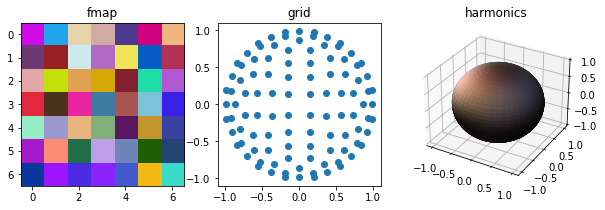

In [ ]:
def visualize_projection(fmap, projector):
  fig = plt.figure(figsize=(10,3))
  ax1 = fig.add_subplot(1,3,1)
  ax1.imshow(ToPILImage()(fmap))
  ax1.set_title('fmap')

  ax2 = fig.add_subplot(1,3,2)
  ax2.scatter(*projector.xyz.T[[0,2]])
  ax2.set_xlim(-1.1, 1.1)
  ax2.set_ylim(-1.1, 1.1)
  ax2.set_aspect('equal')
  ax2.set_title('grid')

  # plot signal on sphere
  u = np.linspace(0, 2*np.pi, 100)
  v = np.linspace(0, np.pi, 101)
  x = np.outer(np.cos(u), np.sin(v))
  y = np.outer(np.sin(u), np.sin(v))
  z = np.outer(np.ones(np.size(u)), np.cos(v))

  harmonics = projector(fmap)
  to_grid = o3.ToS2Grid(projector.lmax, (100, 101))
  signal = to_grid(harmonics.squeeze(0).detach()).permute(2, 1, 0).numpy()
  signal = (signal - signal.min())/(signal.max() - signal.min())

  ax3 = fig.add_subplot(1,3,3, projection='3d')
  ax3.plot_surface(x, y, z, facecolors=signal)
  
  ax3.set_title('harmonics')


FMAP_SHAPE = (3, 7, 7)
projector = Image2SphereProjector(
    FMAP_SHAPE, 
    sphere_fdim=3,
    lmax=4
)
fmap = torch.ones(FMAP_SHAPE).uniform_(0, 1)

# center of image is being placed on north pole in the visualization
# so the lower half should be black (magnitude near zero)

# the mapping to harmonics can distort appearance, it is easiest to 
# see the mapping with a very simple or small fmap (3x3 for instance)
visualize_projection(fmap, projector)


# 3. Define S2 and SO3 Convolution Layers
Here we define the group convolutions over $S^2$ and $SO(3)$ using the [e3nn](e3nn.org) library.  Please see their documentation for more information.

The group convolutions are performed by applying the convolutional theorem: the signal and filter are converted to the fourier domain and then an elementwise multiplication is performed. For more technical details on this approach, please refer to [Cohen et al. (2018)](https://arxiv.org/pdf/1801.10130.pdf%20http://arxiv.org/abs/1801.10130.pdf).

In [ ]:
def s2_irreps(lmax):
  return o3.Irreps([(1, (l, 1)) for l in range(lmax + 1)])

def so3_irreps(lmax):
  return o3.Irreps([(2 * l + 1, (l, 1)) for l in range(lmax + 1)])

def flat_wigner(lmax, alpha, beta, gamma):
  return torch.cat([
    (2 * l + 1) ** 0.5 * o3.wigner_D(l, alpha, beta, gamma).flatten(-2) for l in range(lmax + 1)
  ], dim=-1)

def so3_near_identity_grid(max_beta=np.pi / 8, max_gamma=2 * np.pi, n_alpha=8, n_beta=3, n_gamma=None):
  """Spatial grid over SO3 used to parametrize localized filter

  :return: rings of rotations around the identity, all points (rotations) in
           a ring are at the same distance from the identity
           size of the kernel = n_alpha * n_beta * n_gamma
  """
  if n_gamma is None:
      n_gamma = n_alpha 
  beta = torch.arange(1, n_beta + 1) * max_beta / n_beta
  alpha = torch.linspace(0, 2 * np.pi, n_alpha)[:-1]
  pre_gamma = torch.linspace(-max_gamma, max_gamma, n_gamma)
  A, B, preC = torch.meshgrid(alpha, beta, pre_gamma, indexing="ij")
  C = preC - A
  A = A.flatten()
  B = B.flatten()
  C = C.flatten()
  return torch.stack((A, B, C))


class S2Conv(nn.Module):
  '''S2 group convolution which outputs signal over SO(3) irreps

  :f_in: feature dimensionality of input signal
  :f_out: feature dimensionality of output signal
  :lmax: maximum degree of harmonics used to represent input and output signals
         technically, you can have different degrees for input and output, but
         we do not explore that in our work
  :kernel_grid: spatial locations over which the filter is defined (alphas, betas)
                we find that it is better to parametrize filter in spatial domain
                and project to harmonics at every forward pass.
  '''
  def __init__(self, f_in: int, f_out: int, lmax: int, kernel_grid: tuple):
    super().__init__()
    # filter weight parametrized over spatial grid on S2
    self.register_parameter(
      "w", torch.nn.Parameter(torch.randn(f_in, f_out, kernel_grid.shape[1]))
    )  # [f_in, f_out, n_s2_pts]

    # linear projection to convert filter weights to fourier domain
    self.register_buffer(
      "Y", o3.spherical_harmonics_alpha_beta(range(lmax + 1), *kernel_grid, normalization="component")
    )  # [n_s2_pts, (2*lmax+1)**2]

    # defines group convolution using appropriate irreps
    # note, we set internal_weights to False since we defined our own filter above
    self.lin = o3.Linear(s2_irreps(lmax), so3_irreps(lmax), 
                         f_in=f_in, f_out=f_out, internal_weights=False)

  def forward(self, x):
    '''Perform S2 group convolution to produce signal over irreps of SO(3).
    First project filter into fourier domain then perform convolution

    :x: tensor of shape (B, f_in, (2*lmax+1)**2), signal over S2 irreps
    :return: tensor of shape (B, f_out, sum_l^L (2*l+1)**2)
    '''
    psi = torch.einsum("ni,xyn->xyi", self.Y, self.w) / self.Y.shape[0] ** 0.5
    return self.lin(x, weight=psi)


class SO3Conv(nn.Module):
  '''SO3 group convolution

  :f_in: feature dimensionality of input signal
  :f_out: feature dimensionality of output signal
  :lmax: maximum degree of harmonics used to represent input and output signals
         technically, you can have different degrees for input and output, but
         we do not explore that in our work
  :kernel_grid: spatial locations over which the filter is defined (alphas, betas, gammas)
                we find that it is better to parametrize filter in spatial domain
                and project to harmonics at every forward pass
  '''
  def __init__(self, f_in: int, f_out: int, lmax: int, kernel_grid: tuple):
    super().__init__()

    # filter weight parametrized over spatial grid on SO3
    self.register_parameter(
      "w", torch.nn.Parameter(torch.randn(f_in, f_out, kernel_grid.shape[1]))
    )  # [f_in, f_out, n_so3_pts]

    # wigner D matrices used to project spatial signal to irreps of SO(3)
    self.register_buffer("D", flat_wigner(lmax, *kernel_grid))  # [n_so3_pts, sum_l^L (2*l+1)**2]

    # defines group convolution using appropriate irreps
    self.lin = o3.Linear(so3_irreps(lmax), so3_irreps(lmax), 
                         f_in=f_in, f_out=f_out, internal_weights=False)

  def forward(self, x):
    '''Perform SO3 group convolution to produce signal over irreps of SO(3).
    First project filter into fourier domain then perform convolution

    :x: tensor of shape (B, f_in, sum_l^L (2*l+1)**2), signal over SO3 irreps
    :return: tensor of shape (B, f_out, sum_l^L (2*l+1)**2)
    '''
    psi = torch.einsum("ni,xyn->xyi", self.D, self.w) / self.D.shape[0] ** 0.5
    return self.lin(x, weight=psi)

## Activations
Like normal neural networks, we need to add non-linearities between subsequent group convolution layers.  However, the representation is encoded using the irreps (i.e. coefficients of fourier basis), so we must map back to the spatial domain before applying ReLU's.  Fortunately, `e3nn` provides a module for performing this process (map to spatial -> apply relu -> map back to irreps).

Note: applying ReLU in the spatial domain will introduce high frequencies into the signal which will be lost when mapped back to the truncated fourier series.  This will increase the equivariance error (see Fig. 3 of [Spherical CNNs](https://arxiv.org/pdf/1801.10130.pdf%20http://arxiv.org/abs/1801.10130.pdf)).

In [ ]:
# we can choose the lmax on the input and output, the pointwise activation
# function applied in spatial domain, and the resolution of the spatial grid
# to which the signal is mapped (resolution is for each euler angle)
e3nn.nn.SO3Activation(lmax_in=6, lmax_out=6, act=torch.relu, resolution=10)

SO3Activation (6 -> 6)

# 4. Creating Distribution over SO3 with Wigner-D Coefficients
The output of the SO(3) group convolution is a signal represented by coefficients over the irreps of SO(3) (e.g. the Wigner-D matrices).  We want the output to be a valid probability distribution.  To normalize the signal, 
we sample it at an equally spaced grid over SO(3) rotations then apply a softmax operation.

In [ ]:
def so3_healpix_grid(rec_level: int=3):
    """Returns healpix grid over so3 of equally spaced rotations
   
    https://github.com/google-research/google-research/blob/4808a726f4b126ea38d49cdd152a6bb5d42efdf0/implicit_pdf/models.py#L272
    alpha: 0-2pi around Y
    beta: 0-pi around X
    gamma: 0-2pi around Y
    rec_level | num_points | bin width (deg)
    ----------------------------------------
         0    |         72 |    60
         1    |        576 |    30
         2    |       4608 |    15
         3    |      36864 |    7.5
         4    |     294912 |    3.75
         5    |    2359296 |    1.875
         
    :return: tensor of shape (3, npix)
    """
    n_side = 2**rec_level
    npix = hp.nside2npix(n_side)
    beta, alpha = hp.pix2ang(n_side, torch.arange(npix))
    gamma = torch.linspace(0, 2*np.pi, 6*n_side + 1)[:-1]

    alpha = alpha.repeat(len(gamma))
    beta = beta.repeat(len(gamma))
    gamma = torch.repeat_interleave(gamma, npix)
    return torch.stack((alpha, beta, gamma)).float()

In [ ]:
# define random signal over irreps of so3
B = 1 # batch size
lmax = 6
fdim = 1
num_irreps = sum([(2*l+1)**2 for l in range(lmax+1)])
signal = torch.randn((B, fdim, num_irreps))

# define equally spaced grid over so3
output_xyx = so3_healpix_grid(rec_level=2)
output_wigners = flat_wigner(lmax, *output_xyx)
output_rotmats = o3.angles_to_matrix(*output_xyx)

# convert to spatial domain using healpix grid then apply softmax
logits = torch.matmul(signal, output_wigners.transpose(0, 1)).squeeze(1)
prob = nn.Softmax(dim=1)(logits)

# 5. Fully Implementing I2S with Cross Entropy Loss
Put together all the components:
  1. Image Encoder to generate dense feature map
  2. Projector to map image features to spherical harmonics with orthographic projection
  3. Spherical Convolution with globally supported filter
  4. SO3 Convoltuion with locally supported filter
  5. Map output onto equi-spaced spatial grid to normalize distribution

In [ ]:
def compute_trace(rotA, rotB):
    '''
    rotA, rotB are tensors of shape (*,3,3)
    returns Tr(rotA, rotB.T)
    '''
    prod = torch.matmul(rotA, rotB.transpose(-1, -2))
    trace = prod.diagonal(dim1=-1, dim2=-2).sum(-1)
    return trace

def rotation_error(rotA, rotB):
    '''
    rotA, rotB are tensors of shape (*,3,3)
    returns rotation error in radians, tensor of shape (*)
    '''
    trace = compute_trace(rotA, rotB)
    return torch.arccos(torch.clamp( (trace - 1)/2, -1, 1))

def nearest_rotmat(src, target):
    '''return index of target that is nearest to each element in src
    uses negative trace of the dot product to avoid arccos operation
    :src: tensor of shape (B, 3, 3)
    :target: tensor of shape (*, 3, 3)
    '''
    trace = compute_trace(src.unsqueeze(1), target.unsqueeze(0))

    return torch.max(trace, dim=1)[1]


class I2S(nn.Module):
  '''
  Instantiate I2S-style network for predicting distributions over SO(3) from
  single image
  '''
  def __init__(self, lmax=6, s2_fdim=512, so3_fdim=16):
    super().__init__()
    self.encoder = ImageEncoder()

    self.projector = Image2SphereProjector(
        fmap_shape=self.encoder.output_shape,
        sphere_fdim=s2_fdim,
        lmax=lmax,
    )

    # s2 filter has global support
    s2_kernel_grid = s2_healpix_grid(max_beta=np.inf, rec_level=1)
    self.s2_conv = S2Conv(s2_fdim, so3_fdim, lmax, s2_kernel_grid)

    self.so3_act = e3nn.nn.SO3Activation(lmax, lmax, act=torch.relu, resolution=10)

    # locally supported so3 filter
    so3_kernel_grid = so3_near_identity_grid()
    self.so3_conv = SO3Conv(so3_fdim, 1, lmax, so3_kernel_grid)

    # define spatial grid used to convert output irreps into valid prob distribution
    # we use rec_level=2 which corresponds to ~5000 points, which we find is
    # sufficient for training.  Using denser grids will slow down loss computation
    output_xyx = so3_healpix_grid(rec_level=2)
    self.register_buffer(
        "output_wigners", flat_wigner(lmax, *output_xyx).transpose(0,1)
    )
    self.register_buffer(
        "output_rotmats", o3.angles_to_matrix(*output_xyx)
    )
  
  def forward(self, x):
    '''Returns so3 irreps

    :x: image, tensor of shape (B, 3, 224, 224)
    '''
    x = self.encoder(x)
    x = self.projector(x)
    x = self.s2_conv(x)
    x = self.so3_act(x)
    x = self.so3_conv(x)
    return x
  
  def compute_loss(self, img, gt_rot):
    '''Compute cross entropy loss using ground truth rotation, the correct label
    is the nearest rotation in the spatial grid to the ground truth rotation

    :img: float tensor of shape (B, 3, 224, 224)
    :gt_rotation: valid rotation matrices, tensor of shape (B, 3, 3)
    '''
    x = self.forward(img)
    grid_signal = torch.matmul(x, self.output_wigners).squeeze(1)
    rotmats = self.output_rotmats

    # find nearest grid point to ground truth rotation matrix
    rot_id = nearest_rotmat(gt_rot, rotmats)
    loss = nn.CrossEntropyLoss()(grid_signal, rot_id)

    with torch.no_grad():
        pred_id = grid_signal.max(dim=1)[1]
        pred_rotmat = rotmats[pred_id]
        acc = rotation_error(gt_rot, pred_rotmat)

    return loss, acc.cpu().numpy()

  @torch.no_grad()
  def compute_probabilities(self, img, wigners):
    '''Computes probability distribution over arbitrary spatial grid specified by
    wigners

    Our method can be trained on a sparser spatial resolution, but queried at a much denser
    resolution (up to rec_level=5)
    '''
    x = self.forward(img)
    logits = torch.matmul(x, wigners).squeeze(1)
    return nn.Softmax(dim=1)(logits)

# 6. Visualizing Predicted Distributions

In [ ]:
def plot_so3_distribution(probs: torch.Tensor,
                          rots: torch.Tensor,
                          gt_rotation=None,
                          fig=None,
                          ax=None,
                          display_threshold_probability=0.000005,
                          show_color_wheel: bool=True,
                          canonical_rotation=torch.eye(3),
                         ):
    '''
    Taken from https://github.com/google-research/google-research/blob/master/implicit_pdf/evaluation.py
    '''
    cmap = plt.cm.hsv

    def _show_single_marker(ax, rotation, marker, edgecolors=True, facecolors=False):
        alpha, beta, gamma = o3.matrix_to_angles(rotation)
        color = cmap(0.5 + gamma.repeat(2) / 2. / np.pi)[-1]
        ax.scatter(alpha, beta-np.pi/2, s=2000, edgecolors=color, facecolors='none', marker=marker, linewidth=5)
        ax.scatter(alpha, beta-np.pi/2, s=1500, edgecolors='k', facecolors='none', marker=marker, linewidth=2)
        ax.scatter(alpha, beta-np.pi/2, s=2500, edgecolors='k', facecolors='none', marker=marker, linewidth=2)

    if ax is None:
        fig = plt.figure(figsize=(8, 4), dpi=200)
        fig.subplots_adjust(0.01, 0.08, 0.90, 0.95)
        ax = fig.add_subplot(111, projection='mollweide')

    rots = rots @ canonical_rotation
    scatterpoint_scaling = 3e3
    alpha, beta, gamma = o3.matrix_to_angles(rots)

    # offset alpha and beta so different gammas are visible
    R = 0.02
    alpha += R * np.cos(gamma)
    beta += R * np.sin(gamma)

    which_to_display = (probs > display_threshold_probability)

    # Display the distribution
    ax.scatter(alpha[which_to_display],
               beta[which_to_display]-np.pi/2,
               s=scatterpoint_scaling * probs[which_to_display],
               c=cmap(0.5 + gamma[which_to_display] / 2. / np.pi))
    if gt_rotation is not None:
        if len(gt_rotation.shape) == 2:
            gt_rotation = gt_rotation.unsqueeze(0)
        gt_rotation = gt_rotation @ canonical_rotation
        _show_single_marker(ax, gt_rotation, 'o')
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    if show_color_wheel:
        # Add a color wheel showing the tilt angle to color conversion.
        ax = fig.add_axes([0.86, 0.17, 0.12, 0.12], projection='polar')
        theta = np.linspace(-3 * np.pi / 2, np.pi / 2, 200)
        radii = np.linspace(0.4, 0.5, 2)
        _, theta_grid = np.meshgrid(radii, theta)
        colormap_val = 0.5 + theta_grid / np.pi / 2.
        ax.pcolormesh(theta, radii, colormap_val.T, cmap=cmap)
        ax.set_yticklabels([])
        ax.set_xticklabels([r'90$\degree$', None,
                            r'180$\degree$', None,
                            r'270$\degree$', None,
                            r'0$\degree$'], fontsize=14)
        ax.spines['polar'].set_visible(False)
        plt.text(0.5, 0.5, 'Tilt', fontsize=14,
                 horizontalalignment='center',
                 verticalalignment='center', transform=ax.transAxes)

    plt.show()

/usr/local/lib/python3.9/dist-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
<ipython-input-26-d17da1f564ad>:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(theta, radii, colormap_val.T, cmap=cmap)
<ipython-input-26-d17da1f564ad>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'90$\degree$', None,


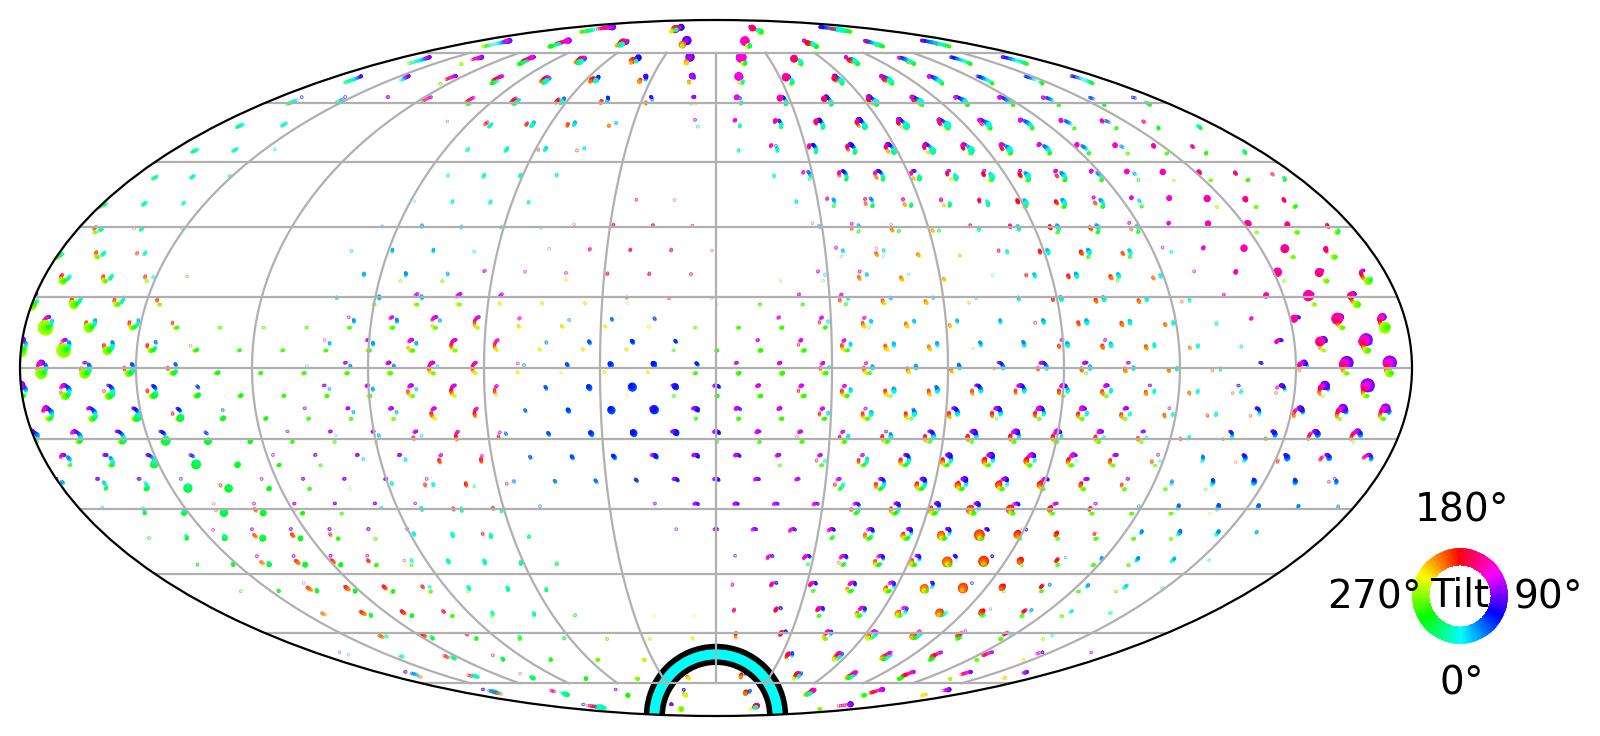

In [ ]:
# create random input for demonstration purposes
img = torch.randn((1, 3, 224, 224))
gt_rot = torch.eye(3).unsqueeze(0)

model = I2S()

# define equally spaced grid over so3
# it can be slow to generate grid for large rec_levels
output_xyx = so3_healpix_grid(rec_level=3) # 37K points
output_wigners = flat_wigner(lmax, *output_xyx).transpose(0, 1)
output_rotmats = o3.angles_to_matrix(*output_xyx)

probs = model.compute_probabilities(img, output_wigners)

plot_so3_distribution(probs[0], output_rotmats, gt_rotation=gt_rot)